In [3]:
from tensorflow.keras.models import load_model

# Load model from file
pen_to_pixel = load_model("pen_to_pixel.keras")
from tensorflow.keras import datasets, layers, models


In [6]:
import os
import glob
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import tensorflow as tf
from PIL import Image

# Acceptable image extensions in SD19 dumps
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".gif"}

# =========================
# Utilities
# =========================
def is_image_file(p: str) -> bool:
    """Check if file is an image (skip .mit and other non-images)."""
    return Path(p).suffix.lower() in IMG_EXTS

def scan_dataset(by_class_dir: str) -> Tuple[List[str], List[int], Dict[str, int], Dict[int, str]]:
    """
    Scan SD19 by_class directory structure:
      by_class/
        <class_name>/
          hsf_1/*.png
          hsf_2/*.png
          ...
    Returns:
      filepaths: list of image file paths
      labels:    list of integer labels
      label2idx: mapping {label_str -> int}
      idx2label: reverse mapping
    """
    filepaths = []
    str_labels = []

    # Top-level label folders (e.g., "30", "7a", "A", etc.)
    label_dirs = sorted([d for d in glob.glob(os.path.join(by_class_dir, "*")) if os.path.isdir(d)])

    # Build label map (alphabetical order for consistency)
    label_names = [os.path.basename(d) for d in label_dirs]
    label2idx = {lab: i for i, lab in enumerate(label_names)}
    idx2label = {i: lab for lab, i in label2idx.items()}

    # Collect image paths + labels
    for lab_dir in label_dirs:
        lab = os.path.basename(lab_dir)
        for p in glob.glob(os.path.join(lab_dir, "**", "*"), recursive=True):
            if os.path.isfile(p) and is_image_file(p):
                filepaths.append(p)
                str_labels.append(lab)

    # Convert labels to integer indices
    int_labels = [label2idx[s] for s in str_labels]

    return filepaths, int_labels, label2idx, idx2label

def load_and_preprocess_image(path: tf.Tensor, img_size=(128, 128)) -> tf.Tensor:
    """
    Load one image, convert to grayscale, resize, scale to [0,1].
    """
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# =========================
# Example Usage
# =========================
if __name__ == "__main__":
    DATASET_DIR = "/home/mudda/Downloads/by_class"   # <- change to your SD19 path
    
    print("🔍 Scanning dataset...")
    filepaths, labels, label2idx, idx2label = scan_dataset(DATASET_DIR)
    print(f"Found {len(filepaths)} images across {len(label2idx)} classes")
    print("Example classes:", list(label2idx.keys())[:10])  # first 10 class names

    # Convert to tf.data.Dataset
    paths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((paths_ds, labels_ds))

    dataset = dataset.map(
        lambda p, y: (load_and_preprocess_image(p), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.shuffle(10000).batch(128).prefetch(tf.data.AUTOTUNE)

    # Test: fetch one batch
    for images, labs in dataset.take(1):
        print("Batch image shape:", images.shape)
        print("Batch labels:", labs[:10].numpy())


🔍 Scanning dataset...
Found 1545923 images across 62 classes
Example classes: ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39']
Batch image shape: (128, 128, 128, 1)
Batch labels: [0 0 0 0 0 0 0 0 0 0]


In [ ]:
# sd19_pen_to_pixel.py
import os
import glob
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image  # noqa: F401  # (kept so you can sanity-check images if needed)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras import mixed_precision
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  

mixed_precision.set_global_policy("mixed_float16")
# only show warnings and errors

# =========================
# Config
# =========================
DATASET_DIR = "/home/mudda/Downloads/by_class"   # <-- change to your SD19 by_class path
IMG_SIZE = (128, 128)                            # (H, W)
BATCH_SIZE = 16
EPOCHS = 3
VAL_SPLIT = 0.15
RANDOM_SEED = 42
SHUFFLE_BUFFER = 10_000

# Save names
BEST_MODEL_PATH = "pen_to_pixel.keras"           # best checkpoint (.keras zip)
FINAL_MODEL_PATH = "pen_to_pixel.keras"    # final save after training
LABELMAP_JSON = "pen_to_pixel_labelmap.json"     # label maps for inference

# Acceptable image extensions in typical SD19 dumps (skip .mit etc.)
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".gif"}


# =========================
# Reproducibility niceties
# =========================
def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# =========================
# Dataset utilities
# =========================
def is_image_file(p: str) -> bool:
    return Path(p).suffix.lower() in IMG_EXTS


def scan_dataset(by_class_dir: str) -> Tuple[List[str], List[str], Dict[str, int], Dict[int, str]]:
    """
    Scans SD19 by_class directory structure:
      by_class/
        <class_name_or_id>/
          hsf_1/*.png ...
          hsf_2/*.png ...
    Returns:
      filepaths: list of image file paths
      str_labels: list of string labels (top-level dir names)
      label2idx: mapping {label_str -> int}
      idx2label: reverse mapping
    """
    filepaths: List[str] = []
    str_labels: List[str] = []

    label_dirs = sorted([d for d in glob.glob(os.path.join(by_class_dir, "*")) if os.path.isdir(d)])
    if not label_dirs:
        raise RuntimeError(f"No class folders found under: {by_class_dir}")

    label_names = [os.path.basename(d) for d in label_dirs]
    label2idx = {lab: i for i, lab in enumerate(label_names)}
    idx2label = {i: lab for lab, i in label2idx.items()}

    for lab_dir in label_dirs:
        lab = os.path.basename(lab_dir)
        for p in glob.glob(os.path.join(lab_dir, "**", "*"), recursive=True):
            if os.path.isfile(p) and is_image_file(p):
                filepaths.append(p)
                str_labels.append(lab)

    if len(filepaths) == 0:
        raise RuntimeError(
            "No image files found. Ensure DATASET_DIR points to SD19 'by_class' root "
            "and that image files (e.g., .png) exist."
        )

    return filepaths, str_labels, label2idx, idx2label


def load_and_preprocess_image(path: tf.Tensor) -> tf.Tensor:
    """
    Reads an image file, converts to grayscale, resizes to IMG_SIZE, scales to [0,1].
    Returns shape (H, W, 1).
    """
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=1, expand_animations=False)  # grayscale
    # Ensure (H, W, 1) static rank
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0
    return img


def build_dataset(paths: List[str], labels: np.ndarray, training: bool) -> tf.data.Dataset:
    ds_paths = tf.data.Dataset.from_tensor_slices(paths)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels.astype(np.int32))
    ds = tf.data.Dataset.zip((ds_paths, ds_labels))

    def _map_fn(p, y):
        img = load_and_preprocess_image(p)
        return img, y

    ds = ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(SHUFFLE_BUFFER, seed=RANDOM_SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


# =========================
# Model: CNN + BiLSTM (CRNN)
# =========================
def build_crnn_model(num_classes: int, input_shape=(128, 128, 1)) -> keras.Model:
    """
    CRNN for single-character classification.
    - CNN extracts feature map (B, H', W', C')
    - Reshape into a sequence across width -> BiLSTM
    - Dense softmax for class logits
    """
    inp = layers.Input(shape=input_shape, name="image")

    # CNN feature extractor
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 64x64

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 32x32

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 16x16

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # Keep 16x16 to have a decent sequence length (width=16)

    # Prepare sequence: (B, H, W, C) -> (B, W, H*C)
    # Use dynamic shape to be safe
    x = layers.Permute((2, 1, 3))(x)  # (B, W, H, C)
    x = layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], tf.shape(t)[1], tf.shape(t)[2] * tf.shape(t)[3]]))(x)

    # RNN
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=False))(x)  # -> (B, 512)

    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    pen_to_pixel = keras.Model(inp, out, name="pen_to_pixel")
    pen_to_pixel.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return pen_to_pixel


# =========================
# Train / Eval
# =========================
def main():
    set_all_seeds(RANDOM_SEED)

    # Optional GPU memory growth
    gpus = tf.config.list_physical_devices("GPU")
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass

    # 1) Scan dataset
    print(f"🔍 Scanning dataset at: {DATASET_DIR}")
    filepaths, str_labels, label2idx, idx2label = scan_dataset(DATASET_DIR)
    print(f"Found {len(filepaths)} images across {len(label2idx)} classes.")
    print("Example classes:", list(label2idx.keys())[:10])

    # 2) Convert string labels to class indices
    y = np.array([label2idx[s] for s in str_labels], dtype=np.int32)

    # 3) Stratified train/val split
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SPLIT, random_state=RANDOM_SEED)
    train_idx, val_idx = next(sss.split(filepaths, y))
    train_paths = [filepaths[i] for i in train_idx]
    val_paths = [filepaths[i] for i in val_idx]
    y_train = y[train_idx]
    y_val = y[val_idx]

    print(f"Train samples: {len(train_paths)} | Val samples: {len(val_paths)}")

    # 4) Build tf.data pipelines (with shuffle for training)
    ds_train = build_dataset(train_paths, y_train, training=True)
    ds_val = build_dataset(val_paths, y_val, training=False)

    # 5) Build model
    num_classes = len(label2idx)
    pen_to_pixel = build_crnn_model(num_classes=num_classes, input_shape=(*IMG_SIZE, 1))
    pen_to_pixel.summary()

    # 6) Callbacks: checkpoint + early stopping + reduce LR
    dirname = os.path.dirname(BEST_MODEL_PATH)
    if dirname:
        os.makedirs(dirname, exist_ok=True)

    ckpt = keras.callbacks.ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,  # save full model in .keras (zip) format
        mode="max",
        verbose=1,
    )
    early = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        mode="max",
        restore_best_weights=True,
        verbose=1,
    )
    rlr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1,
    )

    # 7) Train
    history = pen_to_pixel.fit(
        ds_train,
        validation_data=ds_val,
        epochs=EPOCHS,
        callbacks=[ckpt, early, rlr],
        verbose=1,
    )

    # 8) Save final (best already saved via checkpoint)
    pen_to_pixel.save(FINAL_MODEL_PATH)
    print(f"Saved final model to {FINAL_MODEL_PATH}")

    # 9) Evaluate on validation set
    val_metrics = pen_to_pixel.evaluate(ds_val, verbose=1)
    print("Validation metrics:", dict(zip(pen_to_pixel.metrics_names, val_metrics)))

    # 10) Save label maps (critical for decoding predictions later)
    with open(LABELMAP_JSON, "w") as f:
        json.dump(
            {
                "label2idx": label2idx,
                "idx2label": {int(k): v for k, v in idx2label.items()},
            },
            f,
            indent=2,
        )
    print(f"Saved label maps to {LABELMAP_JSON}")

    # 11) Quick demo predictions on a few validation images
    print("Demo predictions (first 5 validation images):")
    sample_paths = val_paths[:5]
    for p in sample_paths:
        pred_idx, conf = predict_single_image(pen_to_pixel, p)
        print(f"{Path(p).name} -> pred={idx2label[pred_idx]}  conf={conf:.3f}")


def predict_single_image(model: keras.Model, path: str) -> Tuple[int, float]:
    """
    Loads one image path, returns (pred_class_index, confidence).
    """
    img = load_and_preprocess_image(tf.constant(path))
    img = tf.expand_dims(img, axis=0)  # (1, H, W, 1)
    probs = model.predict(img, verbose=0)[0]
    pred_idx = int(tf.argmax(probs).numpy())
    conf = float(tf.reduce_max(probs).numpy())
    return pred_idx, conf


if __name__ == "__main__":
    main()


🔍 Scanning dataset at: /home/mudda/Downloads/by_class
Found 1545923 images across 62 classes.
Example classes: ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39']
Train samples: 1314034 | Val samples: 231889


Model: "pen_to_pixel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_4 (Permute)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 16, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 16, 512)        │     8,914,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,911,422 (41.62 MB)

 Trainable params: 10,910,462 (41.62 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/3
82128/82128 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8233 - loss: 0.5442
Epoch 1: val_accuracy improved from None to 0.87075, saving model to pen_to_pixel.keras
82128/82128 ━━━━━━━━━━━━━━━━━━━━ 6087s 74ms/step - accuracy: 0.8528 - loss: 0.4346 - val_accuracy: 0.8707 - val_loss: 0.3732 - learning_rate: 0.0010
Epoch 2/3
39675/82128 ━━━━━━━━━━━━━━━━━━━━ 1:04:03 91ms/step - accuracy: 0.8657 - loss: 0.3918

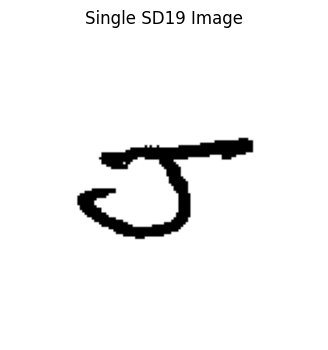

In [1]:
import matplotlib.pyplot as plt

# take 1 batch from dataset
for images, labels in ds.take(1):
    sample_image = images[0].numpy().squeeze()   # (128,128,1) → (128,128)
    sample_label = labels[0].numpy()
    break

plt.imshow(sample_image, cmap="gray")
plt.title(f"Label: {sample_label}")
plt.axis("off")
plt.show()


NameError: name 'ds' is not defined

In [ ]:
# sd19_pen_to_pixel.py
import os
import glob
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image  # noqa: F401  # (kept so you can sanity-check images if needed)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras import mixed_precision
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  

mixed_precision.set_global_policy("mixed_float16")
# only show warnings and errors

# =========================
# Config
# =========================
DATASET_DIR = "/home/mudda/Downloads/by_class"   # <-- change to your SD19 by_class path
IMG_SIZE = (128, 128)                            # (H, W)
BATCH_SIZE = 16
EPOCHS = 10
VAL_SPLIT = 0.15
RANDOM_SEED = 42
SHUFFLE_BUFFER = 10_000

# Save names
BEST_MODEL_PATH = "pen_to_pixel.keras"           # best checkpoint (.keras zip)
FINAL_MODEL_PATH = "pen_to_pixel.keras"    # final save after training
LABELMAP_JSON = "pen_to_pixel_labelmap.json"     # label maps for inference

# Acceptable image extensions in typical SD19 dumps (skip .mit etc.)
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".gif"}


# =========================
# Reproducibility niceties
# =========================
def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# =========================
# Dataset utilities
# =========================
def is_image_file(p: str) -> bool:
    return Path(p).suffix.lower() in IMG_EXTS


def scan_dataset(by_class_dir: str) -> Tuple[List[str], List[str], Dict[str, int], Dict[int, str]]:
    """
    Scans SD19 by_class directory structure:
      by_class/
        <class_name_or_id>/
          hsf_1/*.png ...
          hsf_2/*.png ...
    Returns:
      filepaths: list of image file paths
      str_labels: list of string labels (top-level dir names)
      label2idx: mapping {label_str -> int}
      idx2label: reverse mapping
    """
    filepaths: List[str] = []
    str_labels: List[str] = []

    label_dirs = sorted([d for d in glob.glob(os.path.join(by_class_dir, "*")) if os.path.isdir(d)])
    if not label_dirs:
        raise RuntimeError(f"No class folders found under: {by_class_dir}")

    label_names = [os.path.basename(d) for d in label_dirs]
    label2idx = {lab: i for i, lab in enumerate(label_names)}
    idx2label = {i: lab for lab, i in label2idx.items()}

    for lab_dir in label_dirs:
        lab = os.path.basename(lab_dir)
        for p in glob.glob(os.path.join(lab_dir, "**", "*"), recursive=True):
            if os.path.isfile(p) and is_image_file(p):
                filepaths.append(p)
                str_labels.append(lab)

    if len(filepaths) == 0:
        raise RuntimeError(
            "No image files found. Ensure DATASET_DIR points to SD19 'by_class' root "
            "and that image files (e.g., .png) exist."
        )

    return filepaths, str_labels, label2idx, idx2label


def load_and_preprocess_image(path: tf.Tensor) -> tf.Tensor:
    """
    Reads an image file, converts to grayscale, resizes to IMG_SIZE, scales to [0,1].
    Returns shape (H, W, 1).
    """
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=1, expand_animations=False)  # grayscale
    # Ensure (H, W, 1) static rank
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0
    return img


def build_dataset(paths: List[str], labels: np.ndarray, training: bool) -> tf.data.Dataset:
    ds_paths = tf.data.Dataset.from_tensor_slices(paths)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels.astype(np.int32))
    ds = tf.data.Dataset.zip((ds_paths, ds_labels))

    def _map_fn(p, y):
        img = load_and_preprocess_image(p)
        return img, y

    ds = ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(SHUFFLE_BUFFER, seed=RANDOM_SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


# =========================
# Model: CNN + BiLSTM (CRNN)
# =========================
def build_crnn_model(num_classes: int, input_shape=(128, 128, 1)) -> keras.Model:
    """
    CRNN for single-character classification.
    - CNN extracts feature map (B, H', W', C')
    - Reshape into a sequence across width -> BiLSTM
    - Dense softmax for class logits
    """
    inp = layers.Input(shape=input_shape, name="image")

    # CNN feature extractor
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 64x64

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 32x32

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 16x16

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # Keep 16x16 to have a decent sequence length (width=16)

    # Prepare sequence: (B, H, W, C) -> (B, W, H*C)
    # Use dynamic shape to be safe
    x = layers.Permute((2, 1, 3))(x)  # (B, W, H, C)
    x = layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], tf.shape(t)[1], tf.shape(t)[2] * tf.shape(t)[3]]))(x)

    # RNN
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=False))(x)  # -> (B, 512)

    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    pen_to_pixel = keras.Model(inp, out, name="pen_to_pixel")
    pen_to_pixel.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return pen_to_pixel


# =========================
# Train / Eval
# =========================
def main():
    set_all_seeds(RANDOM_SEED)

    # Optional GPU memory growth
    gpus = tf.config.list_physical_devices("GPU")
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass

    # 1) Scan dataset
    print(f"🔍 Scanning dataset at: {DATASET_DIR}")
    filepaths, str_labels, label2idx, idx2label = scan_dataset(DATASET_DIR)
    print(f"Found {len(filepaths)} images across {len(label2idx)} classes.")
    print("Example classes:", list(label2idx.keys())[:10])

    # 2) Convert string labels to class indices
    y = np.array([label2idx[s] for s in str_labels], dtype=np.int32)

    # 3) Stratified train/val split
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SPLIT, random_state=RANDOM_SEED)
    train_idx, val_idx = next(sss.split(filepaths, y))
    train_paths = [filepaths[i] for i in train_idx]
    val_paths = [filepaths[i] for i in val_idx]
    y_train = y[train_idx]
    y_val = y[val_idx]

    print(f"Train samples: {len(train_paths)} | Val samples: {len(val_paths)}")

    # 4) Build tf.data pipelines (with shuffle for training)
    ds_train = build_dataset(train_paths, y_train, training=True)
    ds_val = build_dataset(val_paths, y_val, training=False)

    # 5) Build model
    num_classes = len(label2idx)
    pen_to_pixel = build_crnn_model(num_classes=num_classes, input_shape=(*IMG_SIZE, 1))
    pen_to_pixel.summary()

    # 6) Callbacks: checkpoint + early stopping + reduce LR
    dirname = os.path.dirname(BEST_MODEL_PATH)
    if dirname:
        os.makedirs(dirname, exist_ok=True)

    ckpt = keras.callbacks.ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,  # save full model in .keras (zip) format
        mode="max",
        verbose=1,
    )
    early = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        mode="max",
        restore_best_weights=True,
        verbose=1,
    )
    rlr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1,
    )

    # 7) Train
    history = pen_to_pixel.fit(
        ds_train,
        validation_data=ds_val,
        epochs=EPOCHS,
        callbacks=[ckpt, early, rlr],
        verbose=1,
    )

    # 8) Save final (best already saved via checkpoint)
    pen_to_pixel.save(FINAL_MODEL_PATH)
    print(f"Saved final model to {FINAL_MODEL_PATH}")

    # 9) Evaluate on validation set
    val_metrics = pen_to_pixel.evaluate(ds_val, verbose=1)
    print("Validation metrics:", dict(zip(pen_to_pixel.metrics_names, val_metrics)))

    # 10) Save label maps (critical for decoding predictions later)
    with open(LABELMAP_JSON, "w") as f:
        json.dump(
            {
                "label2idx": label2idx,
                "idx2label": {int(k): v for k, v in idx2label.items()},
            },
            f,
            indent=2,
        )
    print(f"Saved label maps to {LABELMAP_JSON}")

    # 11) Quick demo predictions on a few validation images
    print("Demo predictions (first 5 validation images):")
    sample_paths = val_paths[:5]
    for p in sample_paths:
        pred_idx, conf = predict_single_image(pen_to_pixel, p)
        print(f"{Path(p).name} -> pred={idx2label[pred_idx]}  conf={conf:.3f}")


def predict_single_image(model: keras.Model, path: str) -> Tuple[int, float]:
    """
    Loads one image path, returns (pred_class_index, confidence).
    """
    img = load_and_preprocess_image(tf.constant(path))
    img = tf.expand_dims(img, axis=0)  # (1, H, W, 1)
    probs = model.predict(img, verbose=0)[0]
    pred_idx = int(tf.argmax(probs).numpy())
    conf = float(tf.reduce_max(probs).numpy())
    return pred_idx, conf


if __name__ == "__main__":
    main()


2025-08-26 08:50:49.713007: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 08:50:49.747151: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-26 08:50:50.452524: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


🔍 Scanning dataset at: /home/mudda/Downloads/by_class
Found 1545923 images across 62 classes.
Example classes: ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39']
Train samples: 1314034 | Val samples: 231889


I0000 00:00:1756178466.044252    3583 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1234 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "pen_to_pixel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 16, 512)        │     8,914,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,911,422 (41.62 MB)

 Trainable params: 10,910,462 (41.62 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10


2025-08-26 08:51:10.828289: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-08-26 08:51:11.190983: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


  602/82128 ━━━━━━━━━━━━━━━━━━━━ 1:50:51 82ms/step - accuracy: 0.3679 - loss: 2.5143

In [ ]:
# sd19_pen_to_pixel.py
import os
import glob
import json
import random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
from PIL import Image  # noqa: F401  # (kept so you can sanity-check images if needed)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras import mixed_precision
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  

mixed_precision.set_global_policy("mixed_float16")
# only show warnings and errors

# =========================
# Config
# =========================
DATASET_DIR = "/home/mudda/Downloads/by_merge"   # <-- change to your SD19 by_class path
IMG_SIZE = (128, 128)                            # (H, W)
BATCH_SIZE = 16
EPOCHS = 3
VAL_SPLIT = 0.15
RANDOM_SEED = 42
SHUFFLE_BUFFER = 10_000

# Save names
BEST_MODEL_PATH = "pen_to_pixel.keras"           # best checkpoint (.keras zip)
FINAL_MODEL_PATH = "pen_to_pixel.keras"    # final save after training
LABELMAP_JSON = "pen_to_pixel_labelmap.json"     # label maps for inference

# Acceptable image extensions in typical SD19 dumps (skip .mit etc.)
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".gif"}


# =========================
# Reproducibility niceties
# =========================
def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


# =========================
# Dataset utilities
# =========================
def is_image_file(p: str) -> bool:
    return Path(p).suffix.lower() in IMG_EXTS


def scan_dataset(by_class_dir: str) -> Tuple[List[str], List[str], Dict[str, int], Dict[int, str]]:
    """
    Scans SD19 by_class directory structure:
      by_class/
        <class_name_or_id>/
          hsf_1/*.png ...
          hsf_2/*.png ...
    Returns:
      filepaths: list of image file paths
      str_labels: list of string labels (top-level dir names)
      label2idx: mapping {label_str -> int}
      idx2label: reverse mapping
    """
    filepaths: List[str] = []
    str_labels: List[str] = []

    label_dirs = sorted([d for d in glob.glob(os.path.join(by_class_dir, "*")) if os.path.isdir(d)])
    if not label_dirs:
        raise RuntimeError(f"No class folders found under: {by_class_dir}")

    label_names = [os.path.basename(d) for d in label_dirs]
    label2idx = {lab: i for i, lab in enumerate(label_names)}
    idx2label = {i: lab for lab, i in label2idx.items()}

    for lab_dir in label_dirs:
        lab = os.path.basename(lab_dir)
        for p in glob.glob(os.path.join(lab_dir, "**", "*"), recursive=True):
            if os.path.isfile(p) and is_image_file(p):
                filepaths.append(p)
                str_labels.append(lab)

    if len(filepaths) == 0:
        raise RuntimeError(
            "No image files found. Ensure DATASET_DIR points to SD19 'by_class' root "
            "and that image files (e.g., .png) exist."
        )

    return filepaths, str_labels, label2idx, idx2label


def load_and_preprocess_image(path: tf.Tensor) -> tf.Tensor:
    """
    Reads an image file, converts to grayscale, resizes to IMG_SIZE, scales to [0,1].
    Returns shape (H, W, 1).
    """
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=1, expand_animations=False)  # grayscale
    # Ensure (H, W, 1) static rank
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0
    return img


def build_dataset(paths: List[str], labels: np.ndarray, training: bool) -> tf.data.Dataset:
    ds_paths = tf.data.Dataset.from_tensor_slices(paths)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels.astype(np.int32))
    ds = tf.data.Dataset.zip((ds_paths, ds_labels))

    def _map_fn(p, y):
        img = load_and_preprocess_image(p)
        return img, y

    ds = ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(SHUFFLE_BUFFER, seed=RANDOM_SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


# =========================
# Model: CNN + BiLSTM (CRNN)
# =========================
def build_crnn_model(num_classes: int, input_shape=(128, 128, 1)) -> keras.Model:
    """
    CRNN for single-character classification.
    - CNN extracts feature map (B, H', W', C')
    - Reshape into a sequence across width -> BiLSTM
    - Dense softmax for class logits
    """
    inp = layers.Input(shape=input_shape, name="image")

    # CNN feature extractor
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 64x64

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 32x32

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # -> 16x16

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # Keep 16x16 to have a decent sequence length (width=16)

    # Prepare sequence: (B, H, W, C) -> (B, W, H*C)
    # Use dynamic shape to be safe
    x = layers.Permute((2, 1, 3))(x)  # (B, W, H, C)
    x = layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], tf.shape(t)[1], tf.shape(t)[2] * tf.shape(t)[3]]))(x)

    # RNN
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=False))(x)  # -> (B, 512)

    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    pen_to_pixel = keras.Model(inp, out, name="pen_to_pixel")
    pen_to_pixel.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return pen_to_pixel


# =========================
# Train / Eval
# =========================
def main():
    set_all_seeds(RANDOM_SEED)

    # Optional GPU memory growth
    gpus = tf.config.list_physical_devices("GPU")
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass

    # 1) Scan dataset
    print(f"🔍 Scanning dataset at: {DATASET_DIR}")
    filepaths, str_labels, label2idx, idx2label = scan_dataset(DATASET_DIR)
    print(f"Found {len(filepaths)} images across {len(label2idx)} classes.")
    print("Example classes:", list(label2idx.keys())[:10])

    # 2) Convert string labels to class indices
    y = np.array([label2idx[s] for s in str_labels], dtype=np.int32)

    # 3) Stratified train/val split
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SPLIT, random_state=RANDOM_SEED)
    train_idx, val_idx = next(sss.split(filepaths, y))
    train_paths = [filepaths[i] for i in train_idx]
    val_paths = [filepaths[i] for i in val_idx]
    y_train = y[train_idx]
    y_val = y[val_idx]

    print(f"Train samples: {len(train_paths)} | Val samples: {len(val_paths)}")

    # 4) Build tf.data pipelines (with shuffle for training)
    ds_train = build_dataset(train_paths, y_train, training=True)
    ds_val = build_dataset(val_paths, y_val, training=False)

    # 5) Build model
    num_classes = len(label2idx)
    pen_to_pixel = build_crnn_model(num_classes=num_classes, input_shape=(*IMG_SIZE, 1))
    pen_to_pixel.summary()

    # 6) Callbacks: checkpoint + early stopping + reduce LR
    dirname = os.path.dirname(BEST_MODEL_PATH)
    if dirname:
        os.makedirs(dirname, exist_ok=True)

    ckpt = keras.callbacks.ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,  # save full model in .keras (zip) format
        mode="max",
        verbose=1,
    )
    early = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=6,
        mode="max",
        restore_best_weights=True,
        verbose=1,
    )
    rlr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1,
    )

    # 7) Train
    history = pen_to_pixel.fit(
        ds_train,
        validation_data=ds_val,
        epochs=EPOCHS,
        callbacks=[ckpt, early, rlr],
        verbose=1,
    )

    # 8) Save final (best already saved via checkpoint)
    pen_to_pixel.save(FINAL_MODEL_PATH)
    print(f"Saved final model to {FINAL_MODEL_PATH}")

    # 9) Evaluate on validation set
    val_metrics = pen_to_pixel.evaluate(ds_val, verbose=1)
    print("Validation metrics:", dict(zip(pen_to_pixel.metrics_names, val_metrics)))

    # 10) Save label maps (critical for decoding predictions later)
    with open(LABELMAP_JSON, "w") as f:
        json.dump(
            {
                "label2idx": label2idx,
                "idx2label": {int(k): v for k, v in idx2label.items()},
            },
            f,
            indent=2,
        )
    print(f"Saved label maps to {LABELMAP_JSON}")

    # 11) Quick demo predictions on a few validation images
    print("Demo predictions (first 5 validation images):")
    sample_paths = val_paths[:5]
    for p in sample_paths:
        pred_idx, conf = predict_single_image(pen_to_pixel, p)
        print(f"{Path(p).name} -> pred={idx2label[pred_idx]}  conf={conf:.3f}")


def predict_single_image(model: keras.Model, path: str) -> Tuple[int, float]:
    """
    Loads one image path, returns (pred_class_index, confidence).
    """
    img = load_and_preprocess_image(tf.constant(path))
    img = tf.expand_dims(img, axis=0)  # (1, H, W, 1)
    probs = model.predict(img, verbose=0)[0]
    pred_idx = int(tf.argmax(probs).numpy())
    conf = float(tf.reduce_max(probs).numpy())
    return pred_idx, conf


if __name__ == "__main__":
    main()
